<a href="https://colab.research.google.com/github/derekfunguk/ADX/blob/main/ADX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
aapl
[*********************100%***********************]  1 of 1 completed


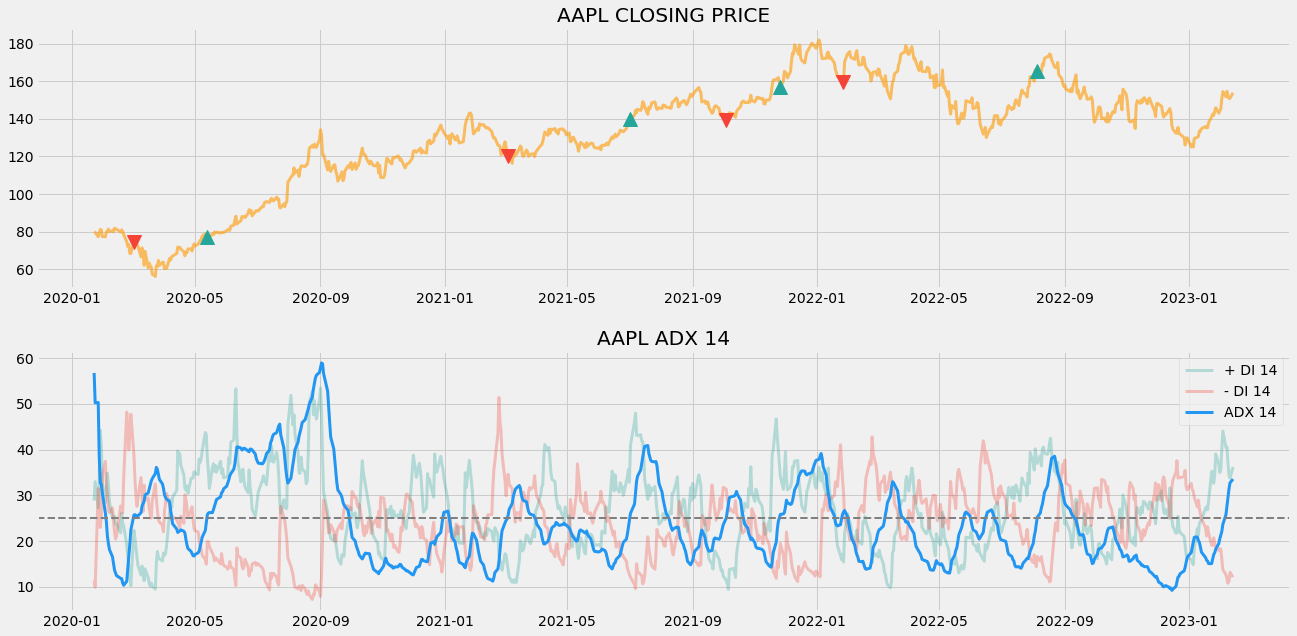

Profit gained from the ADX strategy by investing $100k inAAPL: 18608.45
Profit percentage of the ADX strategy : 18%


In [9]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

!pip install yahoo_fin
!pip install yfinance
!pip install --upgrade pandas-datareader

import yfinance as yf
import pandas as pd
import pandas_datareader.data as pddata

ticker=input().upper()
name = str(ticker)

from datetime import datetime, date, timedelta
begin = '2020-01-01'
yesterday = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
stock_data = yf.download(ticker, start=begin, end=yesterday)

def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth

stock_data['plus_di'] = pd.DataFrame(get_adx(stock_data['High'], stock_data['Low'], stock_data['Close'], 14)[0]).rename(columns = {0:'plus_di'})
stock_data['minus_di'] = pd.DataFrame(get_adx(stock_data['High'], stock_data['Low'], stock_data['Close'], 14)[1]).rename(columns = {0:'minus_di'})
stock_data['adx'] = pd.DataFrame(get_adx(stock_data['High'], stock_data['Low'], stock_data['Close'], 14)[2]).rename(columns = {0:'adx'})
stock_data = stock_data.dropna()

ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(stock_data['Close'], linewidth = 2, color = '#ff9800')
ax1.set_title(name + ' CLOSING PRICE')
ax2.plot(stock_data['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(stock_data['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(stock_data['adx'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title(name + ' ADX 14')

def implement_adx_strategy(prices, pdi, ndi, adx):
    buy_price = []
    sell_price = []
    adx_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if adx[i-1] < 25 and adx[i] > 25 and pdi[i] > ndi[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                adx_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                adx_signal.append(0)
        elif adx[i-1] < 25 and adx[i] > 25 and ndi[i] > pdi[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                adx_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                adx_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            adx_signal.append(0)
            
    return buy_price, sell_price, adx_signal

buy_price, sell_price, adx_signal = implement_adx_strategy(stock_data['Close'], stock_data['plus_di'], stock_data['minus_di'], stock_data['adx'])

ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(stock_data['Close'], linewidth = 3, color = '#ff9800', alpha = 0.6)
ax1.set_title(name + ' CLOSING PRICE')
ax1.plot(stock_data.index, buy_price, marker = '^', color = '#26a69a', markersize = 14, linewidth = 0, label = 'BUY SIGNAL')
ax1.plot(stock_data.index, sell_price, marker = 'v', color = '#f44336', markersize = 14, linewidth = 0, label = 'SELL SIGNAL')
ax2.plot(stock_data['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(stock_data['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(stock_data['adx'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title(name + ' ADX 14')
plt.show()

position = []
for i in range(len(adx_signal)):
    if adx_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(stock_data['Close'])):
    if adx_signal[i] == 1:
        position[i] = 1
    elif adx_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = stock_data['Close']
plus_di = stock_data['plus_di']
minus_di = stock_data['minus_di']
adx = stock_data['adx']
adx_signal = pd.DataFrame(adx_signal).rename(columns = {0:'adx_signal'}).set_index(stock_data.index)
position = pd.DataFrame(position).rename(columns = {0:'adx_position'}).set_index(stock_data.index)

frames = [close_price, plus_di, minus_di, adx, adx_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

stock_data_ret = pd.DataFrame(np.diff(stock_data['Close'])).rename(columns = {0:'returns'})
adx_strategy_ret = []

for i in range(len(stock_data_ret)):
    returns = stock_data_ret['returns'][i]*strategy['adx_position'][i]
    adx_strategy_ret.append(returns)
    
adx_strategy_ret_df = pd.DataFrame(adx_strategy_ret).rename(columns = {0:'adx_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/stock_data['Close'][-1])
adx_investment_ret = []

for i in range(len(adx_strategy_ret_df['adx_returns'])):
    returns = number_of_stocks*adx_strategy_ret_df['adx_returns'][i]
    adx_investment_ret.append(returns)

adx_investment_ret_df = pd.DataFrame(adx_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(adx_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the ADX strategy by investing $100k in' + name + ': {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the ADX strategy : {}%'.format(profit_percentage), attrs = ['bold']))

In [11]:
# SPY ETF COMPARISON

def get_benchmark(start_date, investment_value):
    spy = yf.download('SPY', start=begin, end=yesterday)['Close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)
investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('RSI Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

[*********************100%***********************]  1 of 1 completed
Benchmark profit by investing $100k : 21286.32
Benchmark Profit percentage : 21%
RSI Strategy profit is -3% higher than the Benchmark Profit
